In [53]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [54]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [55]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,...,49.0,114.0,15.4,1.0,0.9,20.0,23.0,13.0,0.0,0.0
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,...,51.0,111.0,16.2,1.0,0.9,30.0,39.0,92.0,0.0,1.0
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,...,52.0,112.0,14.6,2.0,0.9,20.0,20.0,50.0,0.0,1.0
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,...,61.0,119.0,13.4,1.0,0.8,25.0,20.0,18.0,0.0,0.0
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,...,61.0,120.0,13.9,1.0,0.7,20.0,26.0,10.0,0.0,0.0


id: Har bir subyektga yoki shaxsga berilgan noyob identifikator.

age: Subyektning yoshi (yil bilan ifodalangan).

height(cm): Subyektning bo'yi (santimetr bilan o'lchanadi).

weight(kg): Subyektning vazni (kilogramm bilan o'lchanadi).

waist(cm): Subyektning bel atrofi (santimetr bilan o'lchanadi).

eyesight(left): Chap ko'zning ko'rish qobiliyati (ko'rishning sifatini ko'rsatadi, masalan, 1.0 normal ko'rishni anglatadi).

eyesight(right): O'ng ko'zning ko'rish qobiliyati (ko'rishning sifatini ko'rsatadi).

hearing(left): Chap quloqning eshitish qobiliyati (normal yoki eshitish qobiliyatidagi muammolarni ifodalaydi).

hearing(right): O'ng quloqning eshitish qobiliyati.

systolic: Sistolik qon bosimi (yurak qisqarayotganda tomirlar devoridagi bosim o'lchami, odatda mmHg bilan o'lchanadi).

relaxation: Diastolik qon bosimi (yurak dam olayotganda tomirlar devoridagi bosim).

fasting blood sugar: Qonda ro'za tutgan paytdagi qand miqdori (odatda mg/dL bilan o'lchanadi).

Cholesterol: Qondagi umumiy xolesterin miqdori (mg/dL bilan o'lchanadi).

triglyceride: Qondagi triglitseridlar miqdori (yog' turlaridan biri, mg/dL bilan o'lchanadi).

HDL: "Yaxshi" xolesterin (yuqori zichlikdagi lipoprotein, yurak salomatligini ko'rsatadi).

LDL: "Yomon" xolesterin (past zichlikdagi lipoprotein, yuqori bo'lsa, yurak-qon tomir kasalliklari xavfini oshiradi).

hemoglobin: Qondagi gemoglobin miqdori (qizil qon tanachalarida kislorodni tashuvchi protein).

Urine protein: Siydikdagi oqsil miqdori (buyrak funksiyasi holatini ko'rsatishi mumkin).

serum creatinine: Qonda kreatinin miqdori (buyrak faoliyatini o'lchaydi).

AST: Aspartat aminotransferaza fermentining qondagi miqdori (jigar yoki yurak holatini aniqlashda qo'llaniladi).

ALT: Alanin aminotransferaza fermenti (jigar salomatligi uchun muhim ko'rsatkich).

Gtp: Gamma-glutamiltransferaza (jigar va o't pufagi kasalliklari bilan bog'liq).

dental caries: Tish kariyesi mavjudligi (tish kasalligi).

smoking: Chekish holati (odatda chekish statusini ko'rsatadi, masalan, chekuvchi yoki chekmaydigan).

In [56]:
train.isna().mean()*100

id                     0.0
age                    0.0
height(cm)             0.0
weight(kg)             0.0
waist(cm)              0.0
eyesight(left)         0.0
eyesight(right)        0.0
hearing(left)          0.0
hearing(right)         0.0
systolic               0.0
relaxation             0.0
fasting blood sugar    0.0
Cholesterol            0.0
triglyceride           0.0
HDL                    0.0
LDL                    0.0
hemoglobin             0.0
Urine protein          0.0
serum creatinine       0.0
AST                    0.0
ALT                    0.0
Gtp                    0.0
dental caries          0.0
smoking                0.0
dtype: float64

In [57]:
X = train.drop(columns=['id', 'smoking'])
y = train['smoking']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression: 0.8674


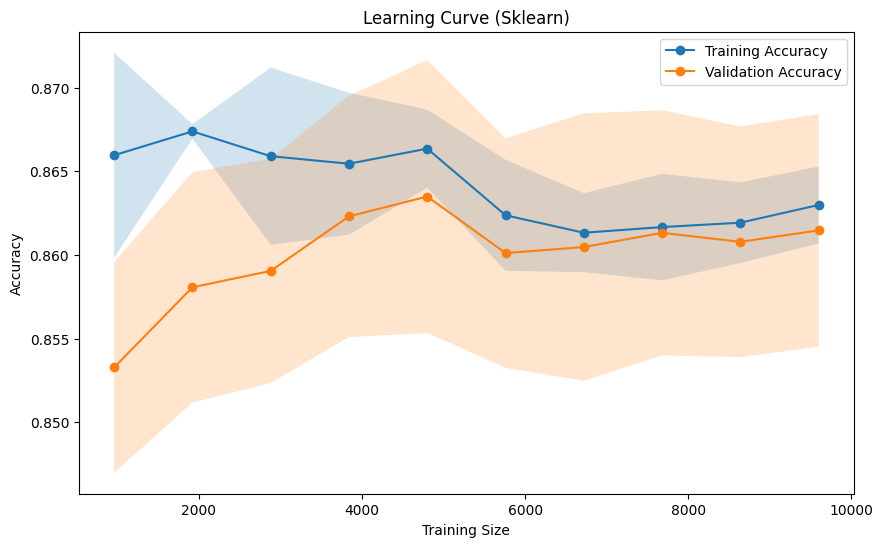

Random Forest: 0.8695


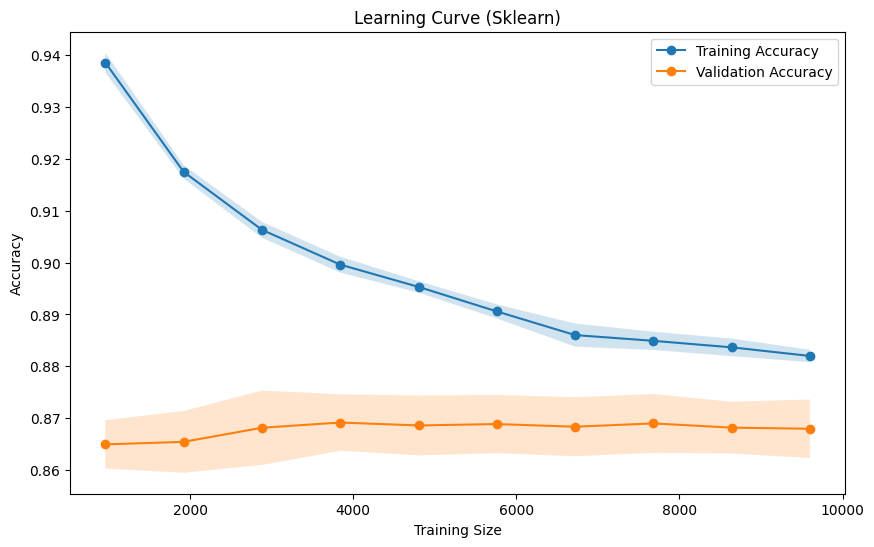

In [59]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=5)
}

roc_auc_results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name}: {roc_auc:.4f}")
    train_size, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="roc_auc", 
    train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_size, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_size, val_mean, 'o-', label='Validation Accuracy')

    plt.fill_between(train_size, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_size, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Sklearn)')
    plt.legend(loc='best')      
    plt.show()
    

In [60]:
train['BMI'] = train['weight(kg)'] / (train['height(cm)'] / 100) ** 2
train['Waist_to_Height_Ratio'] = train['waist(cm)'] / train['height(cm)']
train['Pulse_Pressure'] = train['systolic'] - train['relaxation']
train['Cholesterol_Ratio'] = train['Cholesterol'] / train['HDL']
train['Liver_Enzyme_Ratio'] = train['AST'] / train['ALT']

test['BMI'] = test['weight(kg)'] / (test['height(cm)'] / 100) ** 2
test['Waist_to_Height_Ratio'] = test['waist(cm)'] / test['height(cm)']
test['Pulse_Pressure'] = test['systolic'] - test['relaxation']
test['Cholesterol_Ratio'] = test['Cholesterol'] / test['HDL']
test['Liver_Enzyme_Ratio'] = test['AST'] / test['ALT']

In [61]:
X = train.drop(columns=['id', 'smoking'])
y = train['smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=5)
}

roc_auc_results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name}: {roc_auc:.4f}")

Logistic Regression: 0.8680
Random Forest: 0.8711


In [63]:
def WoE_v2(data, feature_name, target_name):
    df = data.copy()
    woe_table = df.groupby(feature_name)[target_name].value_counts().unstack().rename(columns={1: '# of events', 0: '# of non-events'})
    
    woe_table['Percentage events'] = woe_table['# of events'] / woe_table['# of events'].sum()
    woe_table['Percentage non-events'] = woe_table['# of non-events'] / woe_table['# of non-events'].sum()
    
    woe_table['WoE'] = np.log(woe_table['Percentage events'] / woe_table['Percentage non-events'])
    
    woe_table['Total Observations'] = woe_table['# of events'] + woe_table['# of non-events']
    woe_table['Percent of Observations'] = (woe_table['Total Observations'] / woe_table['Total Observations'].sum() * 100).round(3)

    return woe_table.reset_index()

In [64]:
train['age_cat'] = pd.qcut(train['age'], q=5)

In [65]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,ALT,Gtp,dental caries,smoking,BMI,Waist_to_Height_Ratio,Pulse_Pressure,Cholesterol_Ratio,Liver_Enzyme_Ratio,age_cat
0,0,55.0,170.0,80.0,92.0,1.2,0.8,1.0,1.0,129.0,...,23.0,13.0,0.0,0.0,27.681661,0.541176,55.0,3.571429,0.869565,"(50.0, 85.0]"
1,1,30.0,170.0,80.0,94.0,1.5,1.5,1.0,1.0,128.0,...,39.0,92.0,0.0,1.0,27.681661,0.552941,44.0,3.686275,0.769231,"(19.999, 35.0]"
2,2,45.0,170.0,75.0,84.0,1.0,1.0,1.0,1.0,124.0,...,20.0,50.0,0.0,1.0,25.951557,0.494118,44.0,3.692308,1.000000,"(40.0, 45.0]"
3,3,55.0,150.0,55.0,85.0,0.9,0.5,1.0,1.0,123.0,...,20.0,18.0,0.0,0.0,24.444444,0.566667,44.0,3.163934,1.250000,"(50.0, 85.0]"
4,4,45.0,160.0,55.0,72.0,0.5,0.6,1.0,1.0,117.0,...,26.0,10.0,0.0,0.0,21.484375,0.450000,41.0,3.229508,0.769231,"(40.0, 45.0]"


In [66]:
df_woe = WoE_v2(train, 'age_cat', 'smoking')
df_woe

smoking,age_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(19.999, 35.0]",1594,1918,0.346397,0.168446,0.720973,3512,23.413
1,"(35.0, 40.0]",3541,1936,0.349648,0.374194,-0.067849,5477,36.513
2,"(40.0, 45.0]",1246,579,0.104569,0.131671,-0.230455,1825,12.167
3,"(45.0, 50.0]",934,411,0.074228,0.098700,-0.284947,1345,8.967
4,"(50.0, 85.0]",2148,693,0.125158,0.226989,-0.595326,2841,18.940


smoking,age_cat,# of non-events,# of events,Percentage events,Percentage non-events,WoE,Total Observations,Percent of Observations
0,"(19.999, 35.0]",1594,1918,0.346397,0.168446,0.720973,3512,23.413
1,"(35.0, 40.0]",3541,1936,0.349648,0.374194,-0.067849,5477,36.513
2,"(40.0, 45.0]",1246,579,0.104569,0.131671,-0.230455,1825,12.167
3,"(45.0, 50.0]",934,411,0.074228,0.098700,-0.284947,1345,8.967
4,"(50.0, 85.0]",2148,693,0.125158,0.226989,-0.595326,2841,18.940


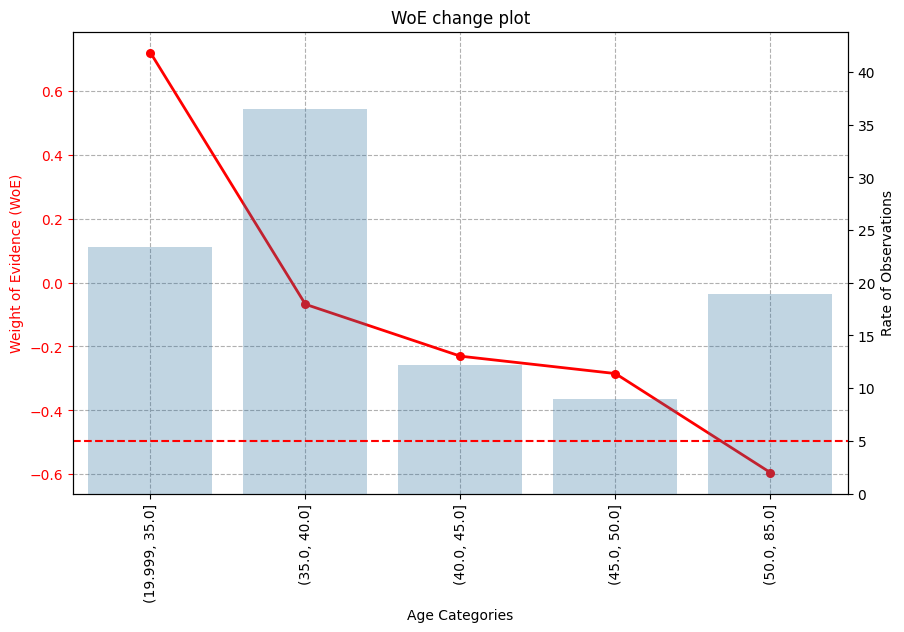

In [67]:
display(df_woe)

fig, ax1 = plt.subplots(figsize=(10, 6)) 
ax2 = ax1.twinx()

sns.pointplot(data=df_woe, x='age_cat', y='WoE', color='red', linewidth=2, ax=ax1)
ax1.set_ylabel('Weight of Evidence (WoE)', color='red')
ax1.tick_params(axis='y', colors='red')
ax1.set_xlabel('Age Categories')
for label in ax1.get_xticklabels():
    label.set_rotation(90)
sns.barplot(data=df_woe, x='age_cat', y='Percent of Observations', alpha=0.3, ax=ax2)
ax2.set_ylabel('Rate of Observations')
ax2.set_ylim(0, df_woe['Percent of Observations'].max() * 1.2)
ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5)
ax1.grid(visible=True, which='major', linestyle='--')
plt.title("WoE change plot")
plt.show()

In [68]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(max_depth=5)
}

roc_auc_results = {}

for model_name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{model_name}: {roc_auc:.4f}")

Logistic Regression: 0.8680
Random Forest: 0.8725
